# **Economic Forecast Model: The 2026 Outlook**

To build a structural forecast, we can't just rely on guessing or simple trend lines. We need to model the "Big Three" economic drivers—**Income, Inflation, and Interest Rates**—plus two powerful behavioral indicators: **Consumer Sentiment** (how people feel) and **Labor Market Trends** (job security).

In this step, we pull the official data directly from the **Federal Reserve (FRED)** so our model is always built on the latest government statistics.

In [4]:
# @title 1. Setup and Data Download
# !pip install pandas_datareader  # Uncomment if running locally

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import datetime

# Configuration for clearer charts
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

# Define Dates: We look back to 2000 to capture multiple economic cycles
start_date = "2000-01-01"
end_date = datetime.date.today()

print("Downloading Data from FRED...")
series_ids = {
    "PCE": "PCE",           # Personal Consumption Expenditures (Spending)
    "Income": "DSPI",       # Disposable Personal Income
    "CPI": "CPIAUCSL",      # CPI Inflation
    "FedFunds": "FEDFUNDS", # Federal Funds Interest Rate
    "Sentiment": "UMCSENT", # U. Mich Consumer Sentiment
    "Unrate": "UNRATE"      # Unemployment Rate
}

# Pull data directly from the Fed
df_raw = DataReader(list(series_ids.values()), "fred", start_date, end_date)
df_raw.columns = series_ids.keys()
df_raw = df_raw.dropna()

print(f"Download complete. Loaded {len(df_raw)} months of economic data.")
print(df_raw.tail()) # Peek at the most recent data

Download complete. Loaded 309 months of economic data.
                  PCE     Income     CPI  FedFunds  Sentiment  Unrate
DATE                                                                 
2025-05-01 20,755.000 22,722.600 320.580     4.330     52.200   4.200
2025-06-01 20,868.400 22,764.100 321.500     4.330     60.700   4.100
2025-07-01 21,010.600 22,864.900 322.132     4.330     61.700   4.200
2025-08-01 21,127.400 22,948.900 323.364     4.330     58.200   4.300
2025-09-01 21,206.600 23,022.400 324.368     4.220     55.100   4.400


# **Optional Step: The "Time Capsule" (Future-Proofing Your Data)**
In professional data science, **reproducibility** is everything. Because economic data is "**living**"—with agencies frequently revising past numbers as new information comes in—your model's results might shift if run six months from now. To prevent this, we add a simple line of code to save a local "snapshot" of our dataset (*my_economic_forecast_data.csv*); this effectively "**freezes**" the data in time, allowing you (or others) to audit the exact numbers used to build this forecast even after the official records change.

In [7]:
# ---------------------------------------------------------
# OPTIONAL STEP
# PRO TIP: Snapshot your data!
# In real-world data science, we save a local copy so our
# results don't change if the government revises past numbers.
# ---------------------------------------------------------
df_economic_data = df_raw
df_economic_data.to_csv('my_economic_forecast_data.csv')

print("Data gathered and saved to CSV.")
df_economic_data.tail()

Data gathered and saved to CSV.


,PCE,Income,CPI,FedFunds,Sentiment,Unrate
DATE,,,,,,
2025-05-01,"20,755.000","22,722.600",320.580,4.330,52.200,4.200
2025-06-01,"20,868.400","22,764.100",321.500,4.330,60.700,4.100
2025-07-01,"21,010.600","22,864.900",322.132,4.330,61.700,4.200
2025-08-01,"21,127.400","22,948.900",323.364,4.330,58.200,4.300
2025-09-01,"21,206.600","23,022.400",324.368,4.220,55.100,4.400


### **2. Transforming Data into Economic Signals**
Raw data is often too noisy to reveal trends. To find the signal, we make three specific adjustments:
1.  **Real Dollars:** We adjust Income and Spending for inflation so we are measuring purchasing power, not just rising prices.
2.  **Year-over-Year Growth:** We look at the % change from 12 months ago to smooth out monthly volatility.
3.  **The "Lag" Effect:** Interest rates don't slow the economy overnight; they take about a year. Similarly, consumer sentiment often predicts spending 3 months in advance. We create "Lagged" variables to capture this reality.

In [8]:
# @title 2. Data Transformation
# Create a copy to keep the raw data safe
df = df_raw.copy()

# A) Real Variables (Adjusting for Inflation)
# We divide by (CPI / 100) to convert Nominal to Real
df["Real_PCE"] = df["PCE"] / (df["CPI"] / 100)
df["Real_Income"] = df["Income"] / (df["CPI"] / 100)

# B) Year-over-Year Growth Rates
# We use 12-month % change to smooth out monthly volatility
df["Spending_Growth"] = df["Real_PCE"].pct_change(12) * 100
df["Income_Growth"] = df["Real_Income"].pct_change(12) * 100
df["Inflation"] = df["CPI"].pct_change(12) * 100

# C) Creating Economic Signals (Lags)
# Interest Rates take ~12 months to fully impact the economy
df["Rates_Lagged"] = df["FedFunds"].shift(12)

# Consumer Sentiment typically leads spending by ~3 months
df["Sentiment_Lag3"] = df["Sentiment"].shift(3)

# Changes in Unemployment matter more than the absolute level
df["Unemployment_Change"] = df["Unrate"].diff(12)

# Remove any empty rows created by the lagging process
model_df = df.dropna()

print("Transformation complete. Data is ready for regression.")
print(model_df[["Spending_Growth", "Income_Growth", "Rates_Lagged", "Sentiment_Lag3"]].tail())

Transformation complete. Data is ready for regression.
            Spending_Growth  Income_Growth  Rates_Lagged  Sentiment_Lag3
DATE                                                                    
2025-05-01            2.608          1.592         5.330          64.700
2025-06-01            2.422          1.110         5.330          57.000
2025-07-01            2.518          1.383         5.330          52.200
2025-08-01            2.614          1.371         5.330          52.200
2025-09-01            2.168          1.290         5.130          60.700


### **3. Visualizing Drivers of Spending**
Before building the model, we check our assumptions. The **Correlation Matrix** below shows us relationships.

* **Green (Positive):** Variables that boost spending (like Income).
* **Red (Negative):** Variables that drag spending down (like High Interest Rates and Unemployment).

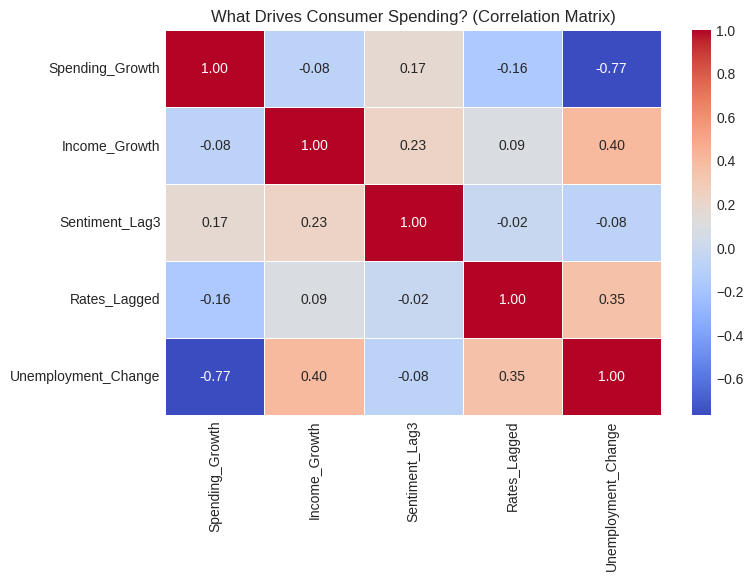

In [9]:
# @title 3. Correlation Matrix
plt.figure(figsize=(8, 5))

# Filter to just the variables we are modeling
corr_matrix = model_df[["Spending_Growth", "Income_Growth", "Sentiment_Lag3",
                        "Rates_Lagged", "Unemployment_Change"]].corr()

# Plot Heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("What Drives Consumer Spending? (Correlation Matrix)")
plt.show()

### **4. Building the Regression Model**
Now we run the **OLS (Ordinary Least Squares)** regression. We split our data into two buckets:
1.  **Training Set (History):** Used to teach the model the relationships.
2.  **Test Set (Last 24 Months):** Held back to check if the model is accurate.

We look closely at the **R-squared** value in the output. This number (0 to 1) tells us what percentage of consumer spending trends can be explained by our five variables.

In [10]:
# @title 4. Train Model & Display Statistics
print("Building the Regression Model...")

# Split: Train on history, Test on the last 24 months
test_months = 24
train = model_df.iloc[:-test_months]
test = model_df.iloc[-test_months:]

# Define the Target (Y) and Predictors (X)
Y_train = train["Spending_Growth"]
X_train = train[["Income_Growth", "Sentiment_Lag3", "Rates_Lagged",
                 "Unemployment_Change", "Inflation"]]
X_train = sm.add_constant(X_train) # Add an intercept

# Fit the OLS Model with HAC (Robust) Standard Errors
model = sm.OLS(Y_train, X_train).fit(cov_type='HAC', cov_kwds={'maxlags': 12})

# Output the Results
print(f"Model R-Squared: {model.rsquared:.3f}")
print(" Interpretation: The model explains {:.1f}% of the spending trends.".format(model.rsquared * 100))
print(model.summary())

Building the Regression Model...
Model R-Squared: 0.679
 Interpretation: The model explains 67.9% of the spending trends.
                            OLS Regression Results                            
Dep. Variable:        Spending_Growth   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     18.70
Date:                Sat, 03 Jan 2026   Prob (F-statistic):           6.26e-16
Time:                        21:03:58   Log-Likelihood:                -501.20
No. Observations:                 273   AIC:                             1014.
Df Residuals:                     267   BIC:                             1036.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                          coef    std err          z      P>|z|      [0.025      0.975]


### **5. Validating the Model**
Charts are often more useful than tables. Here, we ask the model to predict the last 24 months of spending *without* having seen that data during training.

If the **Blue Line** (Model Prediction) tracks the **Black Line** (Actual Data), we know we have a structural model that works and isn't just guessing.

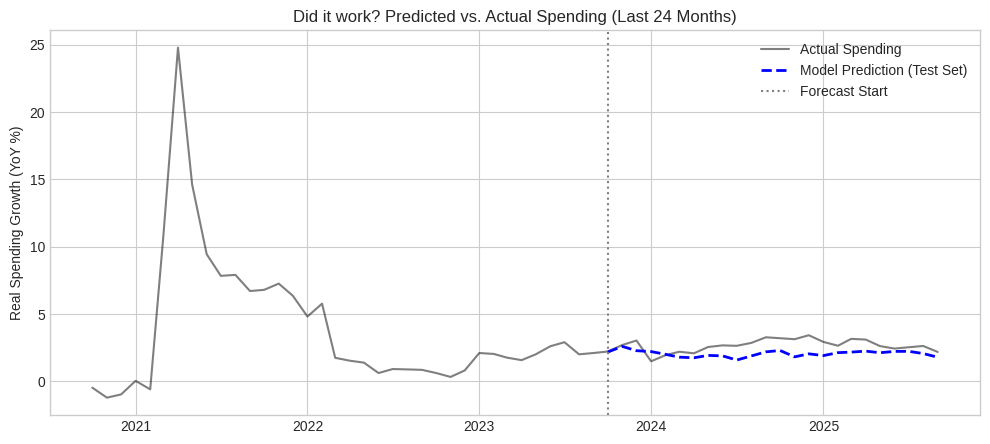

Final Exam Score (Average Error): 0.66%


In [11]:
# @title 5. Actual vs. Predicted (Validation)
# Prepare the Test Data
X_test = sm.add_constant(test[["Income_Growth", "Sentiment_Lag3", "Rates_Lagged",
                               "Unemployment_Change", "Inflation"]])
predictions = model.predict(X_test)

# Plotting
plt.figure(figsize=(12, 5))
# Plot actual history (zoom in on last 5 years)
recent_history = model_df.iloc[-60:]
plt.plot(recent_history.index, recent_history["Spending_Growth"],
         label="Actual Spending", color='black', alpha=0.5)

# Plot the Model's "Blind" Prediction
plt.plot(test.index, predictions, label="Model Prediction (Test Set)",
         color='blue', linewidth=2, linestyle='--')

plt.axvline(test.index[0], color='gray', linestyle=':', label="Forecast Start")
plt.title("Did it work? Predicted vs. Actual Spending (Last 24 Months)")
plt.ylabel("Real Spending Growth (YoY %)")
plt.legend()
plt.show()

# Calculate Accuracy (Mean Absolute Error)
mae = np.mean(np.abs(predictions - test["Spending_Growth"]))
print(f"Final Exam Score (Average Error): {mae:.2f}%")

### **6. The 2026 Forecast**
Finally, we use the model to look ahead.

Because we use **12-month Lagged Rates**, the impact of the Federal Reserve's actions from 2025 is already "baked in." For the other variables, we input our "Soft Landing" scenario assumptions:
* **Income:** Steady growth (~1.8%)
* **Inflation:** Moderating (~3.0%)
* **Sentiment:** Stable (~75.0)
* **Labor:** Slight cooling (+0.2% unemployment)

Generating 2026 Forecast...


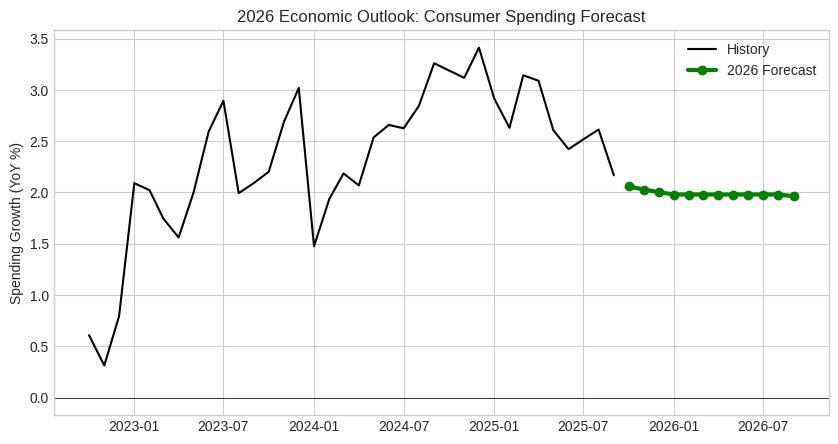

Average Forecasted Growth for 2026: 1.99%


In [12]:
# @title 6. Generate 2026 Forecast
print("Generating 2026 Forecast...")

months_ahead = 12
future_dates = pd.date_range(start=model_df.index[-1], periods=months_ahead+1, freq='MS')[1:]

# --- SCENARIO INPUTS ---
# Adjust these variables to test different economic outcomes
scenario_income = 1.8       # Income grows steadily at 1.8%
scenario_inflation = 3.0    # Inflation settles at 3.0%
scenario_unemployment = 0.2 # Unemployment ticks up slightly (+0.2%)
scenario_sentiment = 75.0   # Sentiment stabilizes near historical averages

# "Baked In" Data: We use ACTUAL rates from last year because of the 12-month lag
known_rates = df_raw["FedFunds"].iloc[-12:].values

# Build the Forecast DataFrame
future_X = pd.DataFrame({
    "const": 1.0,
    "Income_Growth": [scenario_income] * months_ahead,
    "Sentiment_Lag3": [scenario_sentiment] * months_ahead,
    "Rates_Lagged": known_rates, # The 12-month lag means we KNOW this input
    "Unemployment_Change": [scenario_unemployment] * months_ahead,
    "Inflation": [scenario_inflation] * months_ahead
}, index=future_dates)

# Generate Prediction
forecast_2026 = model.predict(future_X)

# Final Plot
plt.figure(figsize=(10, 5))
plt.plot(model_df.index[-36:], model_df["Spending_Growth"].iloc[-36:],
         label="History", color='black')
plt.plot(future_dates, forecast_2026, label="2026 Forecast",
         color='green', linewidth=3, marker='o')

plt.axhline(0, color='black', linewidth=0.5)
plt.title("2026 Economic Outlook: Consumer Spending Forecast")
plt.ylabel("Spending Growth (YoY %)")
plt.legend()
plt.show()

print("Average Forecasted Growth for 2026: {:.2f}%".format(forecast_2026.mean()))